In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import os
import sys
import json

import scipy as sp
from scipy import signal

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os, warnings, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, Sequential, Model
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
SEED = 13
tf.random.set_seed(SEED)

In [3]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)): 
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [4]:
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i]) 
        dataY.append(d_y[i + fore_cast,:])
    
    return np.array(dataX), np.array(dataY)

In [5]:
working_dir = os.getcwd()#os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\Incline\\right_based\SD\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name


c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code\Model\Gait_Phase_Prediction


In [47]:
#inclined_files = ['SKS_2_I.xlsx',  'SKS_3_I.xlsx',  'SKS_4_I.xlsx','SKS_5_I.xlsx', 'SD_2_I.xlsx',  'SD_3_I.xlsx',  'SD_4_I.xlsx','SD_5_I.xlsx']
#file_name = ['TH_4_I.xls', 'TH_2_I.xls', 'TH_3_I.xls']
file_name = ['SD_1_I_r.xls', 'SD_4_I_r.xls', 'SD_2_I_r.xls', 'SD_3_I_r.xls', 'SD_5_I_r.xls']

file_list=[]

for i in range (len(file_name)):
    file_list.append(pd.read_excel(excel_path + file_name[i], sheet_name='Sheet1'))

import random
random.shuffle(file_list)

all_data = pd.concat(file_list, axis=0, ignore_index=True)


In [48]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217324 entries, 0 to 217323
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_hip      217324 non-null  float64
 1   l_ph_ank      217324 non-null  float64
 2   l_ph_fo       217324 non-null  float64
 3   r_ph_hip      217324 non-null  float64
 4   r_ph_ank      217324 non-null  float64
 5   r_ph_fo       217324 non-null  float64
 6   n_lgrf        217324 non-null  float64
 7   n_r_grf       217324 non-null  float64
 8   n_lcop        217324 non-null  float64
 9   n_rcop        217324 non-null  float64
 10  perc_new      217324 non-null  float64
 11  st_sw_phase   217324 non-null  int64  
 12  strike_frame  217324 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 21.6 MB


In [49]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data) - 1):
    if (all_data['perc_new'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table
        

l_ph_hip  l_ph_ank   l_ph_fo  r_ph_hip  r_ph_ank   r_ph_fo    n_lgrf  \
0       0.667562  0.728042  0.076359  0.982605  0.859809  0.727964  0.815270   
1       0.655589  0.729202  0.002251  0.980764  0.845628  0.726730  0.812978   
2       0.639779  0.730084  0.924670  0.978760  0.834772  0.725233  0.809382   
3       0.618352  0.730738  0.869428  0.976566  0.826304  0.723448  0.804271   
4       0.588891  0.731200  0.835912  0.974158  0.819591  0.721338  0.797441   
...          ...       ...       ...       ...       ...       ...       ...   
216121  0.679883  0.711896  0.205673  0.948595  0.144841  0.708321  0.729053   
216122  0.673089  0.715797  0.195595  0.946797  0.116998  0.715494  0.735290   
216123  0.664607  0.718892  0.180182  0.944989  0.078892  0.719660  0.740512   
216124  0.653742  0.721350  0.153982  0.943123  0.030467  0.722083  0.744515   
216125  0.639444  0.723299  0.103641  0.941158  0.978136  0.723385  0.747052   

         n_r_grf         n_lcop    n_rcop   perc_new  st_sw_phase  \
0       0.045487  1.580009e-224 -0.000625   0.000000            1   
1       0.059314  1.421402e-224 -0.000653   0.456621            1   
2       0.074718  1.262874e-224 -0.000669   0.913242            1   
3       0.091168  1.107926e-224 -0.000672   1.369863            1   
4       0.108043  9.592800e-225 -0.000656   1.826484            1   
...          ...            ...       ...        ...          ...   
216121  0.000000   9.960061e-02 -0.000643  97.029703            1   
216122  0.000000   1.006265e-01 -0.000660  97.524752            1   
216123  0.000000   1.016209e-01 -0.000663  98.019802            1   
216124  0.014729   1.025629e-01 -0.000647  98.514851            1   
216125  0.024586   1.034297e-01 -0.000610  99.009901            1   

        strike_frame  
0                  1  
1                  2  
2                  3  
3                  4  
4                  5  
...              ...  
216121           197  
216122           198  
216123           199  
216124           200  
216125           201  

[216126 rows x 13 columns]

In [50]:
source_table = source_table.drop(["n_lgrf","n_r_grf", "l_ph_ank", "r_ph_ank", "l_ph_fo", "r_ph_fo", "l_ph_hip", "n_lcop"], axis = 1)
source_table

r_ph_hip    n_rcop   perc_new  st_sw_phase  strike_frame
0       0.982605 -0.000625   0.000000            1             1
1       0.980764 -0.000653   0.456621            1             2
2       0.978760 -0.000669   0.913242            1             3
3       0.976566 -0.000672   1.369863            1             4
4       0.974158 -0.000656   1.826484            1             5
...          ...       ...        ...          ...           ...
216121  0.948595 -0.000643  97.029703            1           197
216122  0.946797 -0.000660  97.524752            1           198
216123  0.944989 -0.000663  98.019802            1           199
216124  0.943123 -0.000647  98.514851            1           200
216125  0.941158 -0.000610  99.009901            1           201

[216126 rows x 5 columns]

In [51]:
st_sw_idx = len(source_table.columns)
st_sw_idx
source_table.info

<bound method DataFrame.info of         r_ph_hip    n_rcop   perc_new  st_sw_phase  strike_frame
0       0.982605 -0.000625   0.000000            1             1
1       0.980764 -0.000653   0.456621            1             2
2       0.978760 -0.000669   0.913242            1             3
3       0.976566 -0.000672   1.369863            1             4
4       0.974158 -0.000656   1.826484            1             5
...          ...       ...        ...          ...           ...
216121  0.948595 -0.000643  97.029703            1           197
216122  0.946797 -0.000660  97.524752            1           198
216123  0.944989 -0.000663  98.019802            1           199
216124  0.943123 -0.000647  98.514851            1           200
216125  0.941158 -0.000610  99.009901            1           201

[216126 rows x 5 columns]>

In [52]:
x = source_table
x = x.drop(['perc_new'], axis=1)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc_new')
y = source_table[["X","Y"]]
y

data_x = x_scaled


In [53]:
data_y = y.values.reshape(-1,2)

In [54]:
type(data_y)

numpy.ndarray

In [55]:

#data_x,data_y= shuffle_multiple_datasets_based_on_gait_cycle( file_name, excel_path)

X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                        test_size=0.25, 
                        shuffle=False)
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)


In [56]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)


(162083, 10, 4)
(162083, 2)
(54021, 10, 4)
(54021, 2)


In [57]:
train_x.shape

(162083, 10, 4)

In [58]:
n1=validation_x.shape[0]
val_x=validation_x[1:int(n1/10),:]
val_y=validation_y[1:int(n1/10),:]
print(val_x.shape)
print(val_y.shape)

(5401, 10, 4)
(5401, 2)


In [59]:
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.005
	epochs_drop = 10
	lrate=initial_lrate - 0.00001 
	# lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


In [60]:
lr = 0.001
epochs = 20
batch = 128

serie_size = train_x.shape[1]
n_features = train_x.shape[2]
enc_dec_1 = Sequential()
enc_dec_1.add(InputLayer((10, train_x.shape[2])))
enc_dec_1.add(Conv1D(filters=32, kernel_size=3,strides=1,
    activation='relu', padding='same'))            
enc_dec_1.add(AveragePooling1D(pool_size=3))
# enc_dec_1.add(RepeatVector(10))

enc_dec_1.add(LSTM(32,  return_sequences=True))
enc_dec_1.add(LSTM(16,  activation='relu'))
enc_dec_1.add(L.RepeatVector((10)))
enc_dec_1.add(LSTM(16,  return_sequences=True))
enc_dec_1.add(LSTM(32,  activation='relu', return_sequences=True))
enc_dec_1.add(L.TimeDistributed(L.Dense(n_features)))


enc_dec_1.summary()
adam = optimizers.Adam(lr)
enc_dec_1.compile(loss='mse', optimizer=adam)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 10, 32)            416       
                                                                 
 average_pooling1d_1 (Averag  (None, 3, 32)            0         
 ePooling1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 3, 32)             8320      
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector_1 (RepeatVect  (None, 10, 16)           0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 10, 16)           

In [61]:
encoder_decoder_history = enc_dec_1.fit(train_x, train_x, 
                                              batch_size=batch, 
                                              epochs=epochs, 
                                              verbose=1)

Epoch 1/20
1267/1267 [==============================] - 17s 11ms/step - loss: 0.0195
Epoch 2/20
1267/1267 [==============================] - 21s 16ms/step - loss: 0.0034
Epoch 3/20
1267/1267 [==============================] - 20s 16ms/step - loss: 0.0026
Epoch 4/20
1267/1267 [==============================] - 20s 16ms/step - loss: 0.0021
Epoch 5/20
1267/1267 [==============================] - 21s 16ms/step - loss: 0.0018
Epoch 6/20
1267/1267 [==============================] - 21s 17ms/step - loss: 0.0015
Epoch 7/20
1267/1267 [==============================] - 22s 18ms/step - loss: 0.0013
Epoch 8/20
1267/1267 [==============================] - 22s 17ms/step - loss: 0.0011
Epoch 9/20
1267/1267 [==============================] - 20s 16ms/step - loss: 9.3890e-04
Epoch 10/20
1267/1267 [==============================] - 20s 16ms/step - loss: 8.5097e-04
Epoch 11/20
1267/1267 [==============================] - 18s 15ms/step - loss: 7.4616e-04
Epoch 12/20
1267/1267 [============================

In [62]:
encoder = Model(inputs=enc_dec_1.inputs, outputs=enc_dec_1.layers[4].output)
train_encoded = encoder.predict(train_x)
validation_encoded = encoder.predict(validation_x)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

1689/1689 [==============================] - 4s 3ms/step
Encoded time-series shape (162083, 10, 16)
Encoded time-series sample [[3.3049896e+00 1.0316193e-03 1.1750073e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 8.1248140e-01 3.8618662e+00
  3.0908113e+00 1.0438795e-01 7.4850380e-01 6.8301044e+00 2.7899654e+00
  9.1746491e-01]
 [3.3049896e+00 1.0316193e-03 1.1750073e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 8.1248140e-01 3.8618662e+00
  3.0908113e+00 1.0438795e-01 7.4850380e-01 6.8301044e+00 2.7899654e+00
  9.1746491e-01]
 [3.3049896e+00 1.0316193e-03 1.1750073e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 8.1248140e-01 3.8618662e+00
  3.0908113e+00 1.0438795e-01 7.4850380e-01 6.8301044e+00 2.7899654e+00
  9.1746491e-01]
 [3.3049896e+00 1.0316193e-03 1.1750073e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 8.1248140e-01 3.8618662e+00
  3.0908113e+00 1.0438795e-01 

In [63]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 4)]           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 32)            416       
                                                                 
 average_pooling1d_1 (Averag  (None, 3, 32)            0         
 ePooling1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 3, 32)             8320      
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector_1 (RepeatVect  (None, 10, 16)           0         
 or)                                                       

In [64]:
mlp_model = Sequential()
# mlp_model.add(InputLayer(()))

mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1]*train_encoded.shape[2])))
# mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))

mlp_model.add(L.Dense(8, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(2))
mlp_model.summary()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
adam = optimizers.Adam(lr_schedule)

mlp_model.compile(loss='mse', optimizer=adam)
lrate = LearningRateScheduler(step_decay)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                5152      
                                                                 
 dense_9 (Dense)             (None, 8)                 264       
                                                                 
 dense_10 (Dense)            (None, 2)                 18        
                                                                 
Total params: 5,434
Trainable params: 5,434
Non-trainable params: 0
_________________________________________________________________


In [65]:
epochs = 50
# lrate = LearningRateScheduler(step_decay)
monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=3, verbose=1, mode='auto')
train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]*train_encoded.shape[2]))

# train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]))
callback_list = [monitor]
mlp_history = mlp_model.fit(train_encoded_reshaped , train_y, callbacks=callback_list, epochs=epochs, batch_size=batch,  verbose=2)

Epoch 1/50
1267/1267 - 3s - loss: 0.0251 - 3s/epoch - 2ms/step
Epoch 2/50
1267/1267 - 2s - loss: 0.0084 - 2s/epoch - 2ms/step
Epoch 3/50
1267/1267 - 3s - loss: 0.0070 - 3s/epoch - 2ms/step
Epoch 4/50
1267/1267 - 3s - loss: 0.0065 - 3s/epoch - 2ms/step
Epoch 5/50
1267/1267 - 2s - loss: 0.0062 - 2s/epoch - 2ms/step
Epoch 6/50
1267/1267 - 3s - loss: 0.0058 - 3s/epoch - 2ms/step
Epoch 7/50
1267/1267 - 3s - loss: 0.0056 - 3s/epoch - 2ms/step
Epoch 8/50
1267/1267 - 3s - loss: 0.0054 - 3s/epoch - 2ms/step
Epoch 9/50
1267/1267 - 2s - loss: 0.0053 - 2s/epoch - 2ms/step
Epoch 10/50
1267/1267 - 3s - loss: 0.0052 - 3s/epoch - 2ms/step
Epoch 11/50
1267/1267 - 3s - loss: 0.0051 - 3s/epoch - 2ms/step
Epoch 12/50
1267/1267 - 3s - loss: 0.0050 - 3s/epoch - 2ms/step
Epoch 13/50
1267/1267 - 2s - loss: 0.0049 - 2s/epoch - 2ms/step
Epoch 14/50
1267/1267 - 2s - loss: 0.0048 - 2s/epoch - 2ms/step
Epoch 15/50
1267/1267 - 3s - loss: 0.0048 - 3s/epoch - 2ms/step
Epoch 16/50
1267/1267 - 3s - loss: 0.0048 - 3s/ep

In [66]:
train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]*train_encoded.shape[2]))
val_encoded_reshaped=np.reshape(validation_encoded,(validation_encoded.shape[0], validation_encoded.shape[1]*validation_encoded.shape[2]))


In [67]:
# make predictions
trainPredict = mlp_model.predict(train_encoded_reshaped)
testPredict = mlp_model.predict(val_encoded_reshaped)

1689/1689 [==============================] - 2s 1ms/step


In [68]:

print(trainPredict.shape)
print(testPredict.shape)

(162083, 2)
(54021, 2)


In [69]:
from sklearn.metrics import mean_squared_error

trainScore = np.sqrt(mean_squared_error(train_y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.06 RMSE
Test Score: 0.06 RMSE


In [70]:
v = X_test[11:]
v.shape

(54021, 4)

In [71]:
#pred = np.zeros((len(testPredict),1))

#for iter in range(len(testPredict)):
#  x = testPredict[iter][0]
#  y = testPredict[iter][1]
#  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


x_test = scaler.inverse_transform(v)

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

  
  if ((pred[iter] >= 80) & (x_test[iter][-1] <= 20)) : 
    pred[iter] = pred[iter] - 100  
    if abs(pred[iter]) >= 5:
      pred[iter] = 0 
  

  if ((pred[iter] <= 20) & (x_test[iter][-1] >= 150)):
    pred[iter] = 100 - pred[iter]
    if abs(pred[iter]) >= 5:
        pred[iter] = 100

  

  

  #if (pred[iter] > 100):
  #  pred[iter] = pred[iter] - 100

pred1=pd.DataFrame(pred).sort_index().reset_index()

In [72]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [73]:
correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual)):
    if (abs(actual[iter] - pred[iter]) <= (i+1)):
      correct+=1

  print(correct)
  print(len(actual))

  print("Precision ", i+1, ": ", correct * 100/len(actual))

33093
54021
Precision  1 :  61.25951019048148
47242
54021
Precision  2 :  87.45117639436515
52001
54021
Precision  3 :  96.26071342626015
53436
54021
Precision  4 :  98.9170877991892
53803
54021
Precision  5 :  99.59645323115085


In [74]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)

Predicting Percentage RMSE:  1.465748879635956


In [75]:
rmse = 0
length = len(actual)
for i in range(len(actual)):
  if abs (pred[i] - actual[i]) >= 90:
    length -= 1
  else:
    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

54021
54021
1.4657488796359537


33821
54021


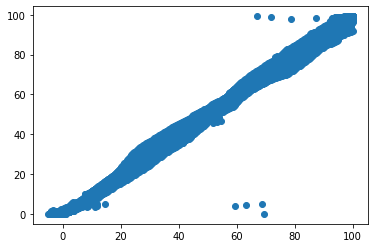

In [76]:
correct = 0

plt.figure()
plt.scatter(pred, actual)
for iter in range(len(actual)):
  if actual[iter]<2 or actual[iter]>98:
    correct+=1
    continue
  if (abs(actual[iter] - pred[iter]) <= 1):
    correct+=1


print(correct)
print(len(actual))

#print("Precision: ", correct * 100/len(actual))

Text(0.5, 1.0, 'Actual vs Prediction')

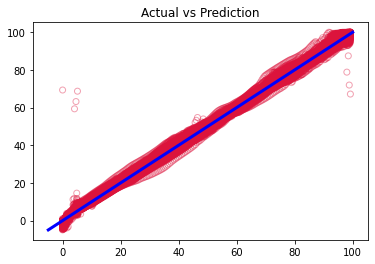

In [77]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

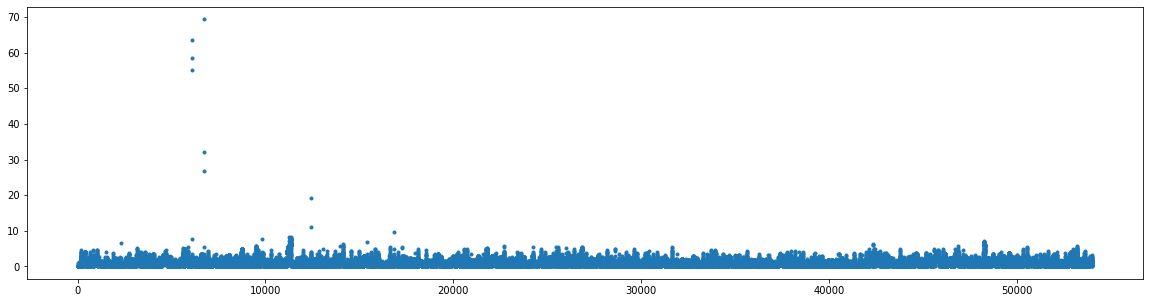

In [78]:
predfig=plt.figure(figsize=(20,5))
dif = abs(actual-pred)

plt.plot(dif,'.')


In [79]:
data_dif = pd.DataFrame(pred)
print(data_dif.to_string())

                0
0       15.878553
1       16.437985
2       16.971179
3       17.475569
4       17.972549
5       18.502850
6       18.987235
7       19.452064
8       19.901670
9       20.333970
10      20.714776
11      21.114105
12      21.589335
13      22.345345
14      22.823950
15      23.264868
16      23.694782
17      24.115831
18      24.530223
19      24.939987
20      25.388589
21      25.851501
22      26.313132
23      26.773325
24      27.231388
25      27.686273
26      28.158628
27      28.651535
28      29.142430
29      29.630522
30      30.114750
31      30.590751
32      31.050251
33      31.507023
34      31.961118
35      32.458380
36      32.991572
37      33.520248
38      34.051361
39      34.539017
40      34.990015
41      35.449198
42      35.912510
43      36.374135
44      36.834138
45      37.292672
46      37.749985
47      38.198387
48      38.637043
49      38.834698
50      38.323863
51      40.285848
52      40.672443
53      41.889392
54      41

In [80]:
act_dif = pd.DataFrame(actual)
print(act_dif.to_string())

               0
0      16.203704
1      16.666667
2      17.129630
3      17.592593
4      18.055556
5      18.518519
6      18.981481
7      19.444444
8      19.907407
9      20.370370
10     20.833333
11     21.296296
12     21.759259
13     22.222222
14     22.685185
15     23.148148
16     23.611111
17     24.074074
18     24.537037
19     25.000000
20     25.462963
21     25.925926
22     26.388889
23     26.851852
24     27.314815
25     27.777778
26     28.240741
27     28.703704
28     29.166667
29     29.629630
30     30.092593
31     30.555556
32     31.018519
33     31.481481
34     31.944444
35     32.407407
36     32.870370
37     33.333333
38     33.796296
39     34.259259
40     34.722222
41     35.185185
42     35.648148
43     36.111111
44     36.574074
45     37.037037
46     37.500000
47     37.962963
48     38.425926
49     38.888889
50     39.351852
51     39.814815
52     40.277778
53     40.740741
54     41.203704
55     41.666667
56     42.129630
57     42.5925

In [81]:
for i in range(len(pred)):
    if (abs(actual[i]-pred[i]) > 50):
        print(i)

6099
6100
6101
6747


In [82]:
strike = pd.DataFrame(x_test[:,-1])
print(strike.to_string())

           0
0       36.0
1       37.0
2       38.0
3       39.0
4       40.0
5       41.0
6       42.0
7       43.0
8       44.0
9       45.0
10      46.0
11      47.0
12      48.0
13      49.0
14      50.0
15      51.0
16      52.0
17      53.0
18      54.0
19      55.0
20      56.0
21      57.0
22      58.0
23      59.0
24      60.0
25      61.0
26      62.0
27      63.0
28      64.0
29      65.0
30      66.0
31      67.0
32      68.0
33      69.0
34      70.0
35      71.0
36      72.0
37      73.0
38      74.0
39      75.0
40      76.0
41      77.0
42      78.0
43      79.0
44      80.0
45      81.0
46      82.0
47      83.0
48      84.0
49      85.0
50      86.0
51      87.0
52      88.0
53      89.0
54      90.0
55      91.0
56      92.0
57      93.0
58      94.0
59      95.0
60      96.0
61      97.0
62      98.0
63      99.0
64     100.0
65     101.0
66     102.0
67     103.0
68     104.0
69     105.0
70     106.0
71     107.0
72     108.0
73     109.0
74     110.0
75     111.0

In [83]:
x_test[18604][:]

array([8.18462779e-01, 3.16530109e-02, 0.00000000e+00, 3.50000000e+01])

In [84]:
print('Predict: ', pred[18604])
print('Actual: ', actual[18604])

Predict:  [16.01952115]
Actual:  [16.19047619]


In [85]:
dif[18604]

array([0.17095504])

In [86]:
#model_save_path="/content/drive/MyDrive/nmchr_lab/models/model_encoder_decoder_MS"

#encoder_decoder.save(model_save_path)

In [87]:
mlp_model = Sequential()
mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=train_encoded.shape[1]))
mlp_model.add(L.Dense(8, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(2))
mlp_model.summary()

adam = optimizers.Adam(lr)
mlp_model.compile(loss='mse', optimizer=adam)
lrate = LearningRateScheduler(step_decay)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 32)                352       
                                                                 
 dense_12 (Dense)            (None, 8)                 264       
                                                                 
 dense_13 (Dense)            (None, 2)                 18        
                                                                 
Total params: 634
Trainable params: 634
Non-trainable params: 0
_________________________________________________________________
